# <center>CITS5508 Lab sheet 3</center>

**Name: Zhanhong He** (or Zhanh He)<br>
**Student number: 22597343**<br>
**Date created:** 28 March 2021<br>
**Last modified:** 1 April 2021<br>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import plot_confusion_matrix, f1_score, mean_squared_error
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVR

# Project 1 Ecoli Dataset

Project 1 is using the **EColi bacteria dataset** [1] supplied on the [UCI Centre for Machine Learning and Intelligent Systems](https://archive.ics.uci.edu/ml/datasets/ecoli).The dataset includes following information.
>1. `Sequence Name`: accession number for the SWISS-PROT database
>2. `mcg`: McGeoch's method for signal sequence recognition.
>3. `gvh`: von Heijne's method for signal sequence recognition.
>4. `lip`: von Heijne's Signal Peptidase II consensus sequence score. Binary attribute.
>5. `chg`: presence of charge on N-terminus of predicted lipoproteins. Binary attribute.
>6. `aac`: score of discriminant analysis of the amino acid content of outer membrane and periplasmic proteins.
>7. `alm1`: score of the ALOM membrane spanning region prediction program.
>8. `alm2`: score of ALOM program after excluding putative cleavable signal regions from the sequence.
>9. `Class`: class distribution.
> **Reference:** 
> [1]: Paul Horton & Kenta Nakai. "A Probablistic Classification System for Predicting the Cellular Localization Sites of Proteins".Intelligent Systems in Molecular Biology, 109-115. St. Louis, USA 1996.

## Task 1. Read, Visualise, and Data cleaning

Task 1 is composed of:<br>
+ 1.1 Read and inspect `ecoli.data` file 
+ 1.2 Provide plotting of visualisation<br>
+ 1.3 Write a funtion to remove **less than 10 instances** class and **non-numerical** data<br>

### 1.1 Read the data
According to the dataset description, we know there are **8** columns in `ecoli.data` file. Select these columns, we can apply `head()` to inspect what instances they have. A interesting fact that **all numerical data** are between `[0,1]`, which will directly affect the feature scaling results.

In [2]:
# 1.1 - Read and inspect the ecoli.data

# Read the data
column_names = ["Sequence Name","mcg","gvh","lip","chg","aac","alm1","alm2","Class"]
data = pd.read_csv('ecoli.data',names=column_names,sep=" ",skipinitialspace=True)

# Inspect the data
data.head(5)

,Sequence Name,mcg,gvh,lip,chg,aac,alm1,alm2,Class
0,AAT_ECOLI,0.49,0.29,0.48,0.5,0.56,0.24,0.35,cp
1,ACEA_ECOLI,0.07,0.40,0.48,0.5,0.54,0.35,0.44,cp
2,ACEK_ECOLI,0.56,0.40,0.48,0.5,0.49,0.37,0.46,cp
3,ACKA_ECOLI,0.59,0.49,0.48,0.5,0.52,0.45,0.36,cp
4,ADI_ECOLI,0.23,0.32,0.48,0.5,0.55,0.25,0.35,cp


### 1.2 Visualisation
The inspect result is identical with the description of `ecoli.name`. Our data doesn't have missing values, and all data are import properly. Both `lip` and `chg` are represented of binary attribute; while `Sequence Name` and `Class` is contributed by object. 

When `scatter matrix` is applied, our visualisation should ignore `Sequence Name` and `Class` because they are `object` content. The results matrix shows the data does not have strong correlation, so we can consider change to `histogram` for simplier obervation.

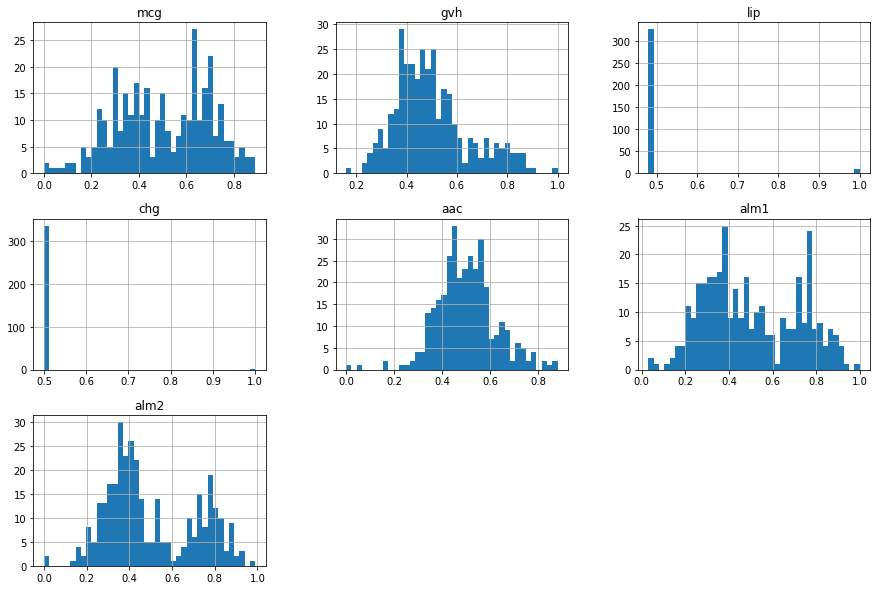

In [3]:
# 1.2 - visualisation of features
feature = ["mcg","gvh","lip","chg","aac","alm1","alm2"]
#scatter_matrix(data[feature],alpha=0.2,figsize=(15,15))

# Histogram for better observation
data[feature].hist(bins=40, figsize=(15,10))
plt.show()

### 1.3 Data Cleaning
Refer to the `ecoli.names` file, the Class Distribution is:
+ Those less than 10 instances class need to remove.<br>

| Abbr | Name | Number | Remove? |
|:-- |:-- | -- | -- |
|  cp  |  cytoplasm  |  143  |  N  |
|  im  |  inner membrane without signal sequence  |  77  | N  |       
|  pp  |  perisplasm  |  52  |  N  |
|  imU |  inner membrane, uncleavable signal sequence  |  35  |  N  |
|  om  |  outer membrane  |  20  |  N  |
|  omL |  outer membrane lipoprotein  |  5  |  Y  |
|  imL |  inner membrane lipoprotein  |  2  |  Y  |
|  imS |  inner membrane, cleavable signal sequence|  2   | Y  |

Among the `object` content, only the `Class` feature is useful **non-numerical** content. Others feature like `Sequence Number` is negligible for analysis.
+ Store the reminding `Class`
+ Remove non-numerical content (i.e.`Sequence Number`)<br> 

This dataset has not missing values, so we just write the cleaning funtion for what we mentioned above.

In [4]:
# 1.3 - Write a funtion for data cleaning

def data_cleaning(df: pd.DataFrame):
    '''
    Input:  dataframe
    >> Drop less than 10 instances classes
    >> Store the reminding classes 
    >> Drop non-numerical content
    Return: dataframe without non-numerical content, the 'Class' alone
    '''
    # Count instances each class
    dfc = df.loc[df.index[:],['Class']]   # Select the column 'Class'
    dfc_size = dfc.groupby('Class').size()
    
    # Drop the data of less than 10 instances class
    for i in range(len(dfc)):            
        if dfc['Class'][i] in dfc_size[dfc_size<10].index:
            df.drop(index=i, inplace=True)
    df.reset_index(inplace=True, drop=True)
    
    # Store the column 'Class' after cleaning
    dfc = df.loc[df.index[:],['Class']]
    
    # Drop the non-numerical column, i.e. objects "Squence Number" and "Class"
    '''column_names = ["Sequence Name","mcg","gvh","lip","chg","aac","alm1","alm2","Class"]'''
    for col in column_names:
        if (df[col].dtype == 'object'):
            df.drop(col,axis=1,inplace=True)
    return df, dfc

## Task2. Decision Tree Classifier (DTClassifier)

Task 2 is composed of:<br>
+ 2.1 Prepare Raw/StandardScaler data<br>
+ 2.2 DTClassifier with Raw train set<br>
+ 2.3 DTClassifier with Standard-Scaled train set<br>
+ 2.4 Investigate 2-3 different values for each hyperparameter

### 2.1 Prepare Raw/StandardScaler data
Notably, our dataset only has **336 instances** according to [data description](https://archive.ics.uci.edu/ml/datasets/ecoli). When the data is too limit, splitting train and test sets are not enough to support our classifier. So in this project, we do not apply `train_test_split`, the cleaning results are directly used as `train` and `target` set. Then use `StandardScaler` to prepare Standard-Scaled `std_train` set; remind `target` set for validation.

In [5]:
# 2.1 - Prepare the Raw train and target set

train, target = data_cleaning(data) # Tips: this code should run only once

In [6]:
# Standard-Scaled train set

std_scale = StandardScaler().fit(train)
std_train = std_scale.transform(train)

### 2.2 Unscaled DTClassifier
Setting`random_state=0` for both DecisionTreeClassifier, so that we can do the fair comparison. For `f1score`, the hyperparameter `average` select to `marco`, but there still some others selection:
>`binary`: Only report results for the class specified by pos_label. This is applicable only if targets (y_{true,pred}) are binary.<br>
>`micro`: Calculate metrics globally by counting the total true positives, false negatives and false positives.<br>
>`macro`: Calculate metrics for each label, and find their unweighted mean. **This does not take label imbalance into account.**<br>
>`weighted`: Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters 'macro' to account for label imbalance; it can result in an F-score that is not between precision and recall.<br>
>`samples`: Calculate metrics for each instance, and find their average (only meaningful for multilabel classification where this differs from accuracy_score).

Since our data 
1. has limited instance 
2. only part of them belongs to binary distribution
3. some imbalance labels (less than 10 instanes classes) has been removed

I believe the `macro` should have a great performance. Apply `grid search` to explore others hyperparameters.


Best hyperparameters for Unscaled DTClassifier: {'criterion': 'gini', 'max_depth': 5, 'max_features': 7, 'min_samples_leaf': 6}

Unscaled DTClassifier f1 score: 0.8373930804670067


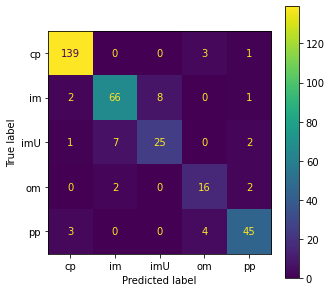

In [7]:
# 2.2 - Unscaled Decision Tree (Raw train set)

# Prepare hyperparamenters
parameters = {'criterion':('gini', 'entropy'), # Criterion expect better result
              'max_depth':[5,6,7],
              'max_features':[5,6,7],
              'min_samples_leaf':[5,6,7]}
tree = DecisionTreeClassifier(random_state=0)  # fix random_state for fair comparison

# Implement of Unscaled Decision Tree
clf = GridSearchCV(tree, parameters,cv=3)
clf.fit(train, target)

# Best Estimator and Parameters - Grid Search
clfbest = clf.best_estimator_
print('\nBest hyperparameters for Unscaled DTClassifier:',clf.best_params_)

# Calculate F1 Score
pred = clfbest.predict(train)
f1score = f1_score(target, pred, average='macro') # average = 'marco','weight',etc
print('\nUnscaled DTClassifier f1 score:',f1score)

# Plotting confusion matrix, with Raw train set
fig, ax = plt.subplots(figsize=(5, 5))
plot_confusion_matrix(clf, train, target, ax=ax)
plt.show()

### 2.3  DTClassifier with Standard-Scaled train set
For adding StandardScaler to DecisionTreeClassifier, replace all `train` by `std_train`. Same hyperparameters are applied for fair comparison.


Best hyperparameters for Standard-Scaled DTClassifier: {'criterion': 'gini', 'max_depth': 5, 'max_features': 7, 'min_samples_leaf': 6}

Standard-Scaled Decision Tree f1 score: 0.8373930804670067


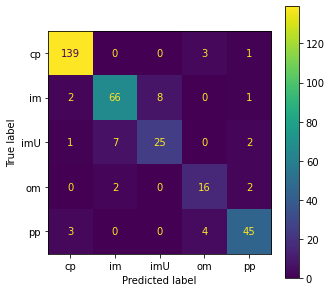

In [8]:
# 2.3 - Standard-Scaled Decision Tree

# StandardScaler Decision Tree
std_clf = GridSearchCV(tree, parameters,cv=3)
std_clf.fit(std_train, target)

# Best Estimator and Parameters - Grid Search
std_clfbest = std_clf.best_estimator_
print('\nBest hyperparameters for Standard-Scaled DTClassifier:',std_clf.best_params_)

# Calculate F1 Score
std_pred = std_clfbest.predict(std_train)
std_f1score = f1_score(target, std_pred, average='macro') # average same with above, for fair comparison
print('\nStandard-Scaled Decision Tree f1 score:', std_f1score)

# Plotting confusion matrix, use Standard-Scaled train set
fig, ax = plt.subplots(figsize=(5, 5))
plot_confusion_matrix(std_clf, std_train, target, ax=ax)
plt.show()

### 2.4 Investigate 2-3 values each hyperparameter
My hypermeter is arranged as:

| hypermeter | values |
| :-- | :-- |
| criterion | gini, entropy |
| max_depth | 5,6,7 |
| min_samples_leaf| 5,6,7 |
| max_features | 5,6,7 |

Both DTClassifier report the best hyperparameter: `criterion='gini'`, `max_depth=5`, `max_features=7`,`min_samples_leaf=6`.

### criterion

The default criterion **Gini Impurity** can makes the computation faster, but **Entropy** produce a more balanced Decision Tree. According to our Textbook, most of time their results are similar, as proven with our DTClassifier results.
>So, should you use Gini impurity or entropy? The truth is, most of the time it does not make a big difference: they lead to similar trees **(p.181)**.

### max_depth
The **max_depth** decide the recursing extent, the split will stop when the maximum depth `max_depth` is reached. Raising `max_depth` can improve accuracy, but too high can also lead to overfitting.
>
>If a Decision Tree is overfitting the training set, it may be a good idea to decrease max_depth, since this will constrain the model, regularizing it **(p.725)**.

### max_features
The **maximum_feaures** is number of features that are evaluated for splitting at each node. Decrease `max_features` can regularize the model (avoid the overfitting). However, decrease this hyperparameter might cause the underfitting, just like my case.

### min_samples_leaf
The **mini_samples_leaf** limit the minimum number of samples a leaf node must have.Decrease this restriction parameter can avoid the overfitting. Just like cutting the tree branch, `min_samples_leaf` can state the minimum amout of branch; when overfitting do not happens, a lower `min_sampes_leaf` will lead a better result. 

## Task3. Investigate f1score & confusion matrix

Notably, when `criterion='entropy'`and the same hyperparameters are applied, the `f1 score`, `best hyperparameters`, `confusion_matrix` of **both Raw and Standard-Scaled DTClassifier** are approximately/totally the same. *(depends on the `random_state` we select)*.
<br>

According to Textbook, one of the reason is:
+ Decision Trees not such affected by scaling the data.
>Decision Trees don’t care whether or not the training data is scaled or centered;
that’s one of the nice things about them. So if a Decision Tree underfits the training set, scaling the input features will just be a waste of time.
>

The others reason comes from the StandardScaler. Our data only distribute between [0,1], and the `hist` shows some of them are approximate to **Normalisation distribution** (or Guassian Distribution), and others are **binary distribution** (`lip`, `chg`).
+ Apply **StandardScaler** to those data will remind their original **(Raw)** distribution structure, implying the similar results.

It is interesting to note that, the result even getting worse if apply improper Scaler. As I tried MinMax Scaler, which will change the data distribution, the DTclassifier f1score turn down from `0.83` (Raw) to `0.62` (MinMax).

# Project 2 Concrete Slump Test Dataset

Project 2 is using the **Concrete Slump Test Data Set** [2] supplied on the [UCI Centre for Machine Learning and Intelligent Systems](https://archive.ics.uci.edu/ml/datasets/Concrete+Slump+Test).The dataset includes following information.

>Data Set Characteristics: Multivariate<br>
>Attribute Characteristics: Real<br>
>Associated Tasks: Regression<br>
>Number of Instances: 103<br>
>Number of Attributes: 10<br>
>Missing Values? N/A<br>
>Area: Computer<br>
>Date Donated: 2009-04-30<br>
>
> **Reference:** 
> [2]: Yeh, I-Cheng, "Modeling slump flow of concrete using second-order regressions and artificial neural networks," Cement and Concrete Composites, Vol.29, No. 6, 474-480, 2007.
## Task 1. Reading and Visualisation
Task 1 is composed of:

+ 1.1 Read and Inspect the data<br>
+ 1.2 Data Visualisation
+ 1.3 Data Preparing

### 1.1 Read and Inspect the data
According to the dataset description, we know there are **10** columns in `slump_test.data` file. Select all columns and apply `head()` to inspect what instances they have, since the named-style are not exactly corresponding to the website description.

In [9]:
# 1.1 - Read and inspect the slump_test.data

# Read all data to inspect columns name
data = pd.read_csv('slump_test.data')
data.head(5)

,No,Cement,Slag,Fly ash,Water,SP,Coarse Aggr.,Fine Aggr.,SLUMP(cm),FLOW(cm),Compressive Strength (28-day)(Mpa)
0,1,273.0,82.0,105.0,210.0,9.0,904.0,680.0,23.0,62.0,34.99
1,2,163.0,149.0,191.0,180.0,12.0,843.0,746.0,0.0,20.0,41.14
2,3,162.0,148.0,191.0,179.0,16.0,840.0,743.0,1.0,20.0,41.81
3,4,162.0,148.0,190.0,179.0,19.0,838.0,741.0,3.0,21.5,42.08
4,5,154.0,112.0,144.0,220.0,10.0,923.0,658.0,20.0,64.0,26.82


### 1.2 Data Visualisation
This project aimming to predict the Compressive Strength by total 7 inputs. We should only visual useful features, thus `Compressive Strength` and `7 inputs` are selected. Use `scatter_matrix` for visualisation.
+ ID: `No`
+ 7 input variables: **`Cement`, `Slag`, `Fly ash`, `Water`, `SP`, `Coarse Aggr`, `Fine Aggr`**
+ 3 output variables: `SLUMP`, `FLOW`, **`Compressive Strength`**<br>

Since our instances are limited, it is hard to concludes features correlation from the scatter matrix. Those histgram graphs suggest that a proper `Scaler` might effectively improve the model results **(Related to Task3 Discussion)**.

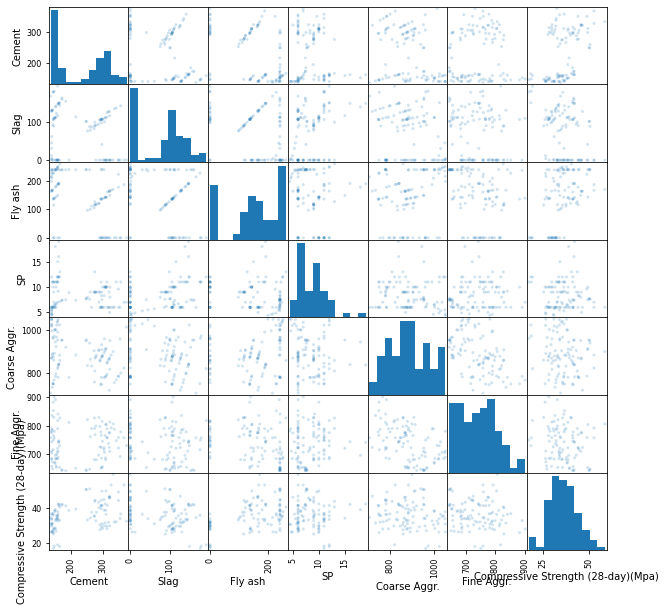

In [10]:
# 1.2 - Visualisation

feature = ["Cement","Slag","Fly ash","SP","Coarse Aggr.","Fine Aggr.","Compressive Strength (28-day)(Mpa)"]
scatter_matrix(data[feature],alpha=0.2,figsize=(10,10))
plt.show()

### 1.3 Data Preparing

This dataset has not missing values, so we just write the cleaning funtion for what we mentioned above. Then, we prepare the Raw and Standard-Scaled data. Similarly with **Project1**, this dataset only have **103 instances**, so the `split_train_test` will not be applied.

+ The output `Compressive Strength` is the target output, which should be stored
+ Reminding 7 input features for training (thus output `SLUMP`,`FLOW`and Identifical number `ID` are **negligible**)

In [11]:
# 1.3 Data preparing, with a small function

def data_preparing(df: pd.DataFrame):
    '''
    Input:  dataframe
    >>Store Comprssive Strength as target output
    >>Keep 7 input features as training data
    >>Standard scaling the train set
    Output:  raw training set, raw target set, standard-scaled training set
    '''
    # Store the useful output as target set
    target = df["Compressive Strength (28-day)(Mpa)"]
    
    # Keep input features only for train set
    train = df.drop(columns=["No","Compressive Strength (28-day)(Mpa)","SLUMP(cm)","FLOW(cm)"])
    
    # Standard scaling train set
    std_scale = StandardScaler().fit(train)
    std_train = std_scale.transform(train)
    
    return train, target, std_train

# Use written function for Preparation
train, target, std_train = data_preparing(data)

## Task 2. Implement three regressors

Task 2 is composed of:

+ 2.1 Regressors Modularization<br>
+ 2.2 Parameters Optimization

### 2.1 Regressors Modularization
Write a general function for three different regressors.

In [12]:
# 2.1 - Write the general structure of regressor

def regressor(model,parameters,train,target):
    '''
    model: tree, svm
    parameters: pama_tree, para_svm
    train: train, std_train
    target: target
    '''
    clf = GridSearchCV(model, parameters,cv=3)
    clf.fit(train, target)
    
    # Best Estimator and Hyperparameters - Grid Search
    clfbest = clf.best_estimator_
    print('\nBest hyperparameters of this model:',clf.best_params_)
    
    # Calculated MSE of best prediction
    pred = clfbest.predict(train) # Use train set to predict
    mse = mean_squared_error(target, pred)
    print('\nMean squared error of this model:',mse)
    
    # Scatter plot for Predition/Target Comparison
    plt.figure(figsize=(8,6))
    plt.scatter(target,pred)
    plt.xlabel("Target True Values")
    plt.ylabel("Regressor Predictions")
    lims = [0, 60]; plt.xlim(lims); plt.ylim(lims)
    _ = plt.plot(lims, lims) # diagonal line
    plt.show()
    
    return pred

### 2.2 Parameters Optimization
Explore the best hyperparameter with `GridSearchCV` **3-fold cross validation**. The following hyperparameters provide the best prediction during my experiment, while `criterion` set to `mse` as question reuqired.

To explore the best hyperparameters, in addition to calculating MSE, I also use linear regression graphs to help judgement.In addition to the theoretical best value, this kind of scatter plot can help us estimate **whether a model is overfitting**. If so, **collect these hypermeters** then **jump to Task3** for the detailed discussion. 

Decision Tree hyperparameters has  been explained in Lab3 Project1, while Support Vector Machine hyperparameters are related to Lab02 Task5 *(Attached on the **end of this document**)*. 

In [13]:
# Prepare parameter

tree = DecisionTreeRegressor(criterion='mse',random_state=1) # criterion set to mse as required
svm = SVR() # Support Vector Machine Regressor

# Decision Tree DTRegressor
param_tree = {'max_depth':[5,7,9],                # parameters optimization, refer to Lab03 Project1
              'max_features':[4,5,6],
              'min_samples_leaf':[3,4,5]}

# Support Vector Machine SVRegressor
param_svm = {'kernel':('linear', 'poly', 'rbf'),  # parameters optimization, refer to Lab02 Task2
             'C':[1,5,10],
             'gamma':('scale', 'auto')}


Best hyperparameters of this model: {'max_depth': 5, 'max_features': 4, 'min_samples_leaf': 3}

Mean squared error of this model: 4.452921325705039


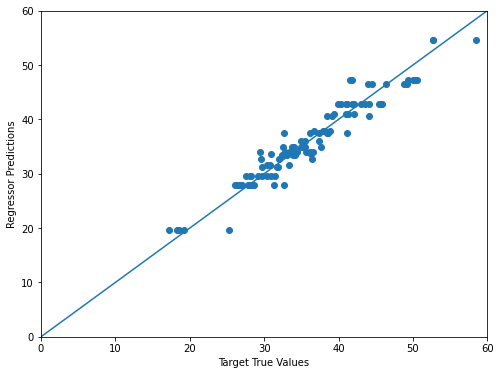

In [14]:
# 2.2 - Unscaled Decision Tree

pred = regressor(tree,param_tree,train,target) # Use Raw train set


Best hyperparameters of this model: {'max_depth': 5, 'max_features': 4, 'min_samples_leaf': 3}

Mean squared error of this model: 4.452921325705039


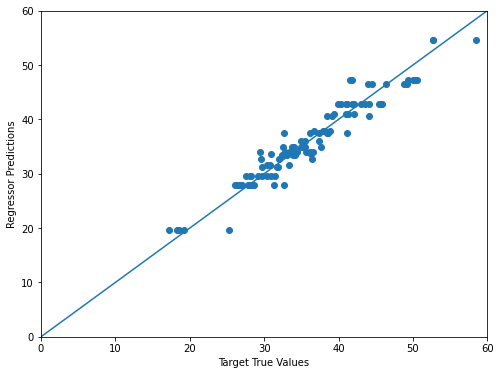

In [15]:
# 2.3 - Standard-Scaled Decision Tree

pred = regressor(tree,param_tree,std_train,target) # Use Standard-Scaled train set


Best hyperparameters of this model: {'C': 5, 'gamma': 'scale', 'kernel': 'linear'}

Mean squared error of this model: 6.488153557959371


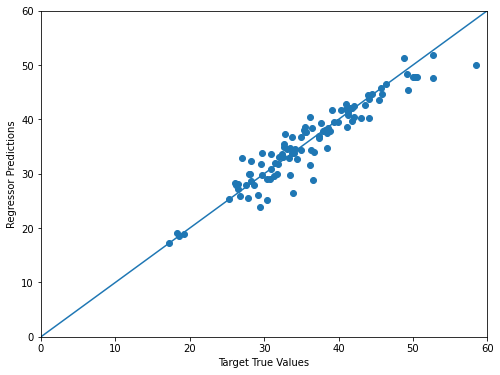

In [16]:
# 2.4 - Standard-Scaled Support Vector Machine

pred = regressor(svm,param_svm,std_train,target) # Use Standard-Scaled train set

During my experimental 3-fold cross validation. Same as previous tasks, the **Standard-Scaled DTRegressor** and **Unscaled DTRegressor** performace are **approximately/totally the same**, so just record a group of hyperparameters representing both of them.

+ The `mse` of SVM reaches about 6.5 and does not drop anymore, so I think this is the limit of the ability of SVM Regressor, and record this set of best hyperparameters: `{'C': 5, 'gamma': 'scale', 'kernel': 'linear'}`
+ The best performance of regression tree appears when: `{'max_depth': 7, 'max_features': 5, 'min_samples_leaf': 3}`<br>

Indeed, the Decission Tree Regressor has possibility to be furtherly optimized, because the effect of `random_state` is unpredictable. Howver, refer to its scatter plotting, this result is good enough, and further optimization may lead to overfitting.

## Task 3. Result Discussion 
The Mean Square Error and Scatter Plotting indicates that Decision Tree Regressor is more suitable for processing this dataset, comparing with Support Vector Machine. Based on the above hyperparameters and MSE comparisons, I made the conclusion that:

Although SVM is suitable for processing data sets with a small amount of data, it is still more suitable for processing binary data tasks. Since our data is distributing within multiple scales (i.e. [0,20], [0,800], etc), even process with StandardScaler, the performance of SVM still lags behind Decision Trees.

Additionally, I catched an overfitting example.

+ When `{'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}`, the SVM Regression got the `mse = 0.0091`, which is 100% overfitting result (see **Section 3.1**). Time to plot a fitting curve to vertify our opinion, refer to the **Section 3.2**.Even only the first input `Cement` is checked, the results diagram clearly shows the overfitting curve of SVM Regressor.



Best hyperparameters of this model: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}

Mean squared error of this model: 0.009082680694550092


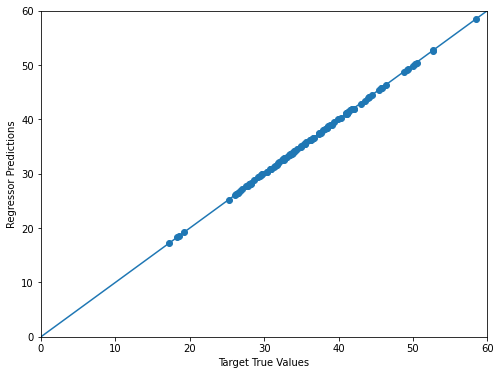

In [17]:
# 3.1 - Overfitting Examples - SVSVRegressor
param_overfit = {'kernel':('linear', 'poly', 'rbf'),  # parameters optimization
             'C':[100,101],
             'gamma':('scale', 'auto')}
pred = regressor(svm,param_overfit,std_train,target)

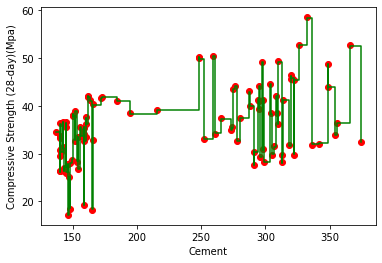

In [18]:
# 3.2 - Checking first input 'Cement' fitting results

# Arrange Cement as x-axis
train_sort = train.loc[:,['Cement']].sort_values(by= 'Cement')
x_axis = train_sort.values 

# Data has one decimal place at most, so interval set to 0.1 for better curve
x_grid = np.arange(min(x_axis),max(x_axis),0.1) 
x_grid = x_grid.reshape((len(x_grid),1))

# Arrange 'Compressive Strength' as y-axis
target_sort = target.reindex(train_sort.index).values
plt.scatter(x_axis,target_sort,color = 'red') # Plot raw data as reference

# Use prediction result to plot fitting curve
pred_sort = pd.DataFrame(pred).reindex(train_sort.index).values
plt.plot(x_axis,pred_sort,color = 'green',drawstyle="steps-post")
plt.xlabel('Cement')
plt.ylabel('Compressive Strength (28-day)(Mpa)') 
plt.show()

This SVM Regressor is overfitting, undoubtedly.

## Lab02 Task 5. Support Vector Classifier

### 5.1 - SVClassifier & hyperparameter
For the Support Vector Classifier, primately we can use 3 different kernel: `linear` for the liner hyperplane, and `rbf` & `poly` for non-linear hyperplane ![avatar](https://miro.medium.com/max/875/1*zqEbdsAbN4QqDdJ6L5pjnw.png)<br>
Since we have mentioned to use `rbf` kernel for better results, the others hyperparameter will be:

1. `gamma`: the higher `gamma` value tries to exactly fit the training dataset<br>\+ Increasing gamma might leads to overfitting<br>\- A small gamma such as `gamma=0.1` (i.e. approximate to linear hyperplane) also implying an poor fitting result<br>
<br>
2. `C`: the penalty parameter of the error term; or, trade off classification accuray and decision margin maximization<br>\+ Larger C,the optimization will choose smaller-margin hyperplane when classify correctly<br>\- Smaller C, optimization try to keep a large-margin hyperplane even they have some wrong classification

After several attempts at `gamma` and `C`, comparing the accuracy with `score()`, I found two good results when `gamma=0.5, C=30` or `gamma=1, C=3`.This indicates the effects of `gamma` and `C` on accuracy are not independent of each other (they have an joint effect on *SVClassifier*).
